# Verifiable Logistic Regression

We use Orion to implement a verifiable ZKML model (logistic regression). For the purposes of the hackathon, we generate synthetic data. However, additional modifications can be done to allow for more complicated datasets. For a more detailed explanation of Logistic regression, please refer to [ESL 2](https://hastie.su.domains/Papers/ESLII.pdf)

## Generating Data

(150, 2) (150,)
(100, 2) (100,) (50, 2) (50,)


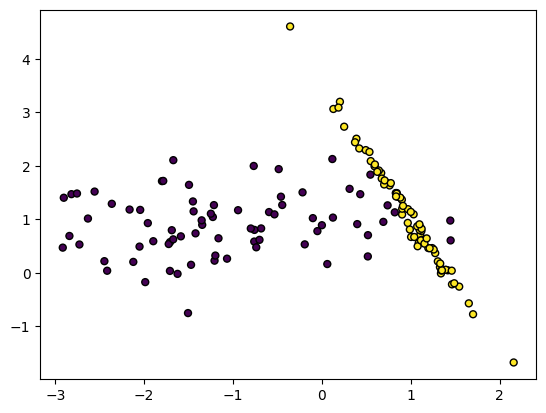

In [1]:
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

data = make_classification(
    n_samples=150, 
    n_classes=2, 
    n_clusters_per_class=1, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_repeated=0, 
    random_state=SEED
)
X = data[0]
y = data[1]
print(X.shape, y.shape)

X_train, y_train = X[:100, :], y[:100]
X_test, y_test = X[100:, :], y[100:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=25, edgecolor="k");

## Creating the classifier

In [2]:
# add a bias term
X_train = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1)
X_test = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
print(X_train.shape, X_test.shape)

(100, 3) (50, 3)


## Defining some helper functions

In [3]:
# sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# log-loss function (function to minimize)
def loss(y, y_pred):
    return (-y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred)).mean()

# gradient of log-loss function
def gradient(X, y, y_pred, n):
    return np.dot(X.T, (y_pred - y)) / n

In [4]:
# Hyperparams

# learning rate
alpha = 0.5
num_iter = 100

# weight matrix
theta = np.zeros(X_train.shape[1])
# number of samples
n = y_train.size 

print(theta.shape, y_train.size)

(3,) 100


## Training loop

In [5]:
initial_loss = 0
cur_loss = 0
for i in range(num_iter):

    y_pred = sigmoid(np.dot(X_train, theta))
    cur_loss = loss(y_train, y_pred)

    if i == 0:
        initial_loss = cur_loss

    if i % 25 == 0:
        print("Loss: {}".format(cur_loss))

    grad = gradient(X_train, y_train, y_pred, n)
    # update weights
    theta -= alpha * grad

Loss: 0.6931471805599453
Loss: 0.2804670809587363
Loss: 0.2521493733504439
Loss: 0.23692535634244064


## Evaluate how model performed on training data

In [6]:
y_pred = sigmoid(np.dot(X_train, theta))
pred = y_pred.round()

final_loss = loss(y_train, y_pred)

print("Accuracy: {}".format((pred == y_train).mean()))
print("Final loss: {}".format(final_loss))

Accuracy: 0.91
Final loss: 0.2265326979918364


## Evaluation on test data

In [7]:
y_pred = sigmoid(np.dot(X_test, theta))
pred = y_pred.round()

print("Accuracy: {}".format((pred == y_test).mean()))

Accuracy: 0.94


## Generating Cairo

We first have to convert the floats to FP16x16 format.

In [8]:
def decimal_to_fp16x16(num):

    whole_num = int(num)
    fractional_part = int((num - whole_num) * 65536)
    fp_number = (whole_num << 16) + fractional_part
    return fp_number

In [9]:
import os

tensor_name = ["X_train", "Y_train", "X_test", "Y_test"]

def generate_cairo_files(data, name):

    os.makedirs("../src/generated", exist_ok=True)

    with open(f"../src/generated/{name}.cairo", "w") as f:
        f.write(
            "use array::ArrayTrait;\n" +
            "use orion::operators::tensor::{core::{Tensor, TensorTrait, ExtraParams}, implementations::impl_tensor_fp::Tensor_fp};\n" +
            "use orion::numbers::fixed_point::{core::{FixedTrait, FixedType, FixedImpl}, implementations::fp16x16::core::FP16x16Impl};\n" +
            "\n" + f"fn {name}() -> Tensor<FixedType>" + "{\n\n" + 
            "let mut shape = ArrayTrait::new();\n"
        )
        for dim in data.shape:
            f.write(f"shape.append({dim});\n")
    
        f.write("let mut data = ArrayTrait::new();")
        for val in np.nditer(data.flatten()):
            f.write(f"data.append(FixedTrait::new({abs(int(decimal_to_fp16x16(val)))}, {str(val < 0).lower()}));\n")
        f.write(
            "let extra = ExtraParams { fixed_point: Option::Some(FixedImpl::FP16x16(())) };\n" + 
            "let tensor = TensorTrait::<FixedType>::new(shape.span(), data.span(), Option::Some(extra));\n" +
            "return tensor;\n}"
        )

with open(f"../src/generated.cairo", "w") as f:
    for n in tensor_name:
        f.write(f"mod {n};\n")

generate_cairo_files(X_train, "X_train")
generate_cairo_files(X_test, "X_test")
generate_cairo_files(y_train, "Y_train")
generate_cairo_files(y_test, "Y_test")

Also convert `alpha` to FP16x16

In [10]:
print(decimal_to_fp16x16(alpha))

32768


Also get an estimate for the last loss value

In [11]:
print(decimal_to_fp16x16(initial_loss))
print(decimal_to_fp16x16(final_loss))

45426
14846


The generated code is quite ugly.
Run `scarb fmt` to auto-format the files.

Run `scarb test` to run the tests. You should see an output of `0xb172` and `0x39fd` as the initial and final training loss respectively.

This corresponds to decimal values of `45426` and `14845` which is the same as the Python output.